In [422]:
import sys
import json
import os
import glob
from collections import defaultdict
import heapq

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import *

sys.setrecursionlimit(10**6)

In [200]:
BASE_PATH = '/Users/vinay/ub/spring-22/CSE573-CVIP/OCR/data/test_cases/testcase_000001'

In [56]:
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

In [186]:
def groundtruth(idx, img, show=False):
    y, x, h, w = gt[idx]['bbox']
    if show:
        plt.imshow(img[x:x+w, y:y+h], cmap='gray')
    return img[x:x+w, y:y+h]

In [128]:
def read_image(img_path, show=False):
    """Reads an image into memory as a grayscale array.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if show:
        show_image(img)

    return img

In [129]:
def merge_ch(image):
    h, w, ch = image.shape
    if ch > 1:
        image = np.mean(image, axis=2)
    return image

In [3]:
def threshold(image, val=0.0, reverse=False):
    h, w = image.shape

    if reverse:
        background = image[:, :] > val
    else:
        background = image[:, :] < val
        
    image[~background] = 255
    image[background] = 0

    return image

In [310]:
class Recognition:
    def __init__(self, matcher, measure=None, n=50):
        self.matcher = matcher
        self.bf = cv2.BFMatcher()
        self.n = n
        
    def match(self, img1, img2):
        score = 0
        kp_1, dsc_1 = self.matcher.detectAndCompute(img1, None)
        kp_2, dsc_2 = self.matcher.detectAndCompute(img2, None)
        
        matches = self.bf.match(dsc_1, dsc_2)
        matches = sorted(matches, key = lambda x:x.distance)

        if matches:
            print(f'n_matches: {len(matches)}')
            dist = sum([match.distance for match in matches[:self.n+1]])
            if dist == 0:
                score = 100
            else:
                score = (min(self.n+1, len(matches))/dist) * 100
        img = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:self.n+1], None, flags=2)
        
        return [match.distance for match in matches], score, img

recog_sift = Recognition(sift, n=50)
recog_orb = Recognition(orb, n=10)

In [406]:
def n_cross_corr(a, b):
    return correlation(a, b)

In [8]:
def get_neighbours(k):
    neighbours = [
        [1, 0],
        [0, 1],
        [-1, 0],
        [0, -1],
    ]
    if k == 8:
        diag_neighbours = [
            [-1, -1],
            [1, 1],
            [-1, 1],
            [1, -1]
        ]
        neighbours += diag_neighbours

    return neighbours

def connected_components(arr, p, components, h, foreground, n_dir=8):
    arr = arr.copy()
    height, width = len(arr), len(arr[0])
    visited = set()
    
    def dfs(i, j, p):
        nonlocal height, width, arr, visited, components
        if i < 0 or i >= height or j < 0 or j >= width or arr[i][j] == -1 or (i, j) in visited:
            return
       
        visited.add((i, j))
        arr[i][j] = p
        components[p]['left'] = min(components[p].get('left', float('inf')), i+h)
        components[p]['right'] = max(components[p].get('right', float('-inf')), i+h)
        components[p]['top'] = min(components[p].get('top', float('inf')), j)
        components[p]['bottom'] = max(components[p].get('bottom', float('-inf')), j)
        neighbour_idx = get_neighbours(n_dir)
        
        for x, y in neighbour_idx:
            dfs(i+x, j+y, p)
    
    for j in range(width):
        for i in range(height):
            if arr[i][j] == foreground and (i, j) not in visited:
                dfs(i, j, p)
                p += 1
                
    return p

In [9]:
def get_component(components, idx, img, show=False):
    component = components[idx]
    left, right = component['left'], component['right']
    top, bottom = component['top'], component['bottom']
    image = img[left:right+1, top:bottom+1]
    if show:
        _ = plt.imshow(image, cmap='gray')
    
    return (left, top, right-left+1, bottom-top+1), image

In [10]:
def gaussian_kernel(size, sigma):
    kernel_1d = np.linspace(- (size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(kernel_1d) / np.square(sigma))
    kernel_2d = np.outer(gauss, gauss)
    return kernel_2d / np.sum(kernel_2d)

In [520]:
def convolve(image, kernel, stride, padding=0, flip=True):
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    h = ((img_h - k_h + (2 * padding)) // stride) + 1
    w = ((img_w - k_w + (2 * padding)) // stride) + 1
    
    if flip:
        kernel = np.flipud(np.fliplr(kernel))
    output = []
    image = np.pad(image, pad_width=padding)

    for i in range(0, img_h-k_h+1, stride):
        for j in range(0, img_w-k_w+1, stride):
            region = image[i:i+k_h, j:j+k_w]
            output.append(np.multiply(region, kernel).sum())

    output = np.asarray(output).reshape(h, w)
    return output

In [12]:
def gaussian_pyramid(image, n, kernel_len=5, sigma=1):
    image = image.copy()
    res = []
    for i in range(n):
        image = convolve(
            image=image,
            kernel=gaussian_kernel(
                size=kernel_len,
                sigma=sigma,
            ),
            stride=2,
        )
        res.append(image)

    return res

In [105]:
def otsu(image, *args, **kwargs):
    pixel_number = image.shape[0] * image.shape[1]
    mean_weight = 1.0 / pixel_number
    his, bins = np.histogram(image, np.arange(0, 257))
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)

    for t in bins[1:-1]:
        pcb = np.sum(his[:t])
        pcf = np.sum(his[t:])
        Wb = pcb * mean_weight
        Wf = pcf * mean_weight

        mub = np.sum(intensity_arr[:t] * his[:t]) / float(pcb)
        muf = np.sum(intensity_arr[t:] * his[t:]) / float(pcf)

        value = Wb * Wf * (mub - muf) ** 2

        if value > final_value:
            final_thresh = t
            final_value = value

    output = image.copy()
    output[image > final_thresh] = 255
    output[image < final_thresh] = 0

    return output

In [13]:
def expand(image, factor=2):
    "Nearest neighbour interpolation"
    img_h, img_w = image.shape
    h, w = img_h * factor, img_w * factor
    output = []

    for i in range(img_h):
        for j in range(img_w):
            for _ in range(factor):
                output.append(image[i][j])
        for _ in range(factor-1):
            output += output[-img_w*factor:]

    output = np.asarray(output).reshape(h, w)
    return output

In [14]:
def extract_features(image, detector):
    keypoints, desc = detector.detectAndCompute(image, None)
    return keypoints, desc

In [15]:
def sim_cosine(a, b):
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim

In [16]:
def norm_l2(a, b):
    return np.linalg.norm(np.asarray(a)-np.asarray(b))

In [17]:
class Matcher:
    def __init__(self, s_idx, t_idx, score):
        self.s_idx = s_idx
        self.t_idx = t_idx
        self.score = score

In [19]:
def g_noise(image, var=0.5):
    row, col = image.shape
    mean = 0
    var = var
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma, (row, col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    return noisy.astype(np.uint8)

In [467]:
def matcher(s_desc, t_desc, measure, thresh=0.8, reverse=False):
    arr = []

    for s_idx, s_d in enumerate(s_desc):
        heap = []
        for t_idx, t_d in enumerate(t_desc):
            score = measure(s_d, t_d)
            heapq.heappush(heap, score)
            
        if len(heap) >= 2:
            min_1 = heapq.heappop(heap)
            min_2 = heapq.heappop(heap)
            
            print(min_1/min_2)
            
            if (min_1/min_2) <= thresh:
                arr.append(round(min_1, 2))

    return sorted(arr, reverse=reverse)

In [ ]:
def matcher(s_desc, t_desc, measure, thresh=0.8, reverse=False):
    arr = []

    for s_idx, s_d in enumerate(s_desc):
        heap = []
        for t_idx, t_d in enumerate(t_desc):
            score = measure(s_d, t_d)
            heapq.heappush(heap, score)
            
        if len(heap) >= 2:
            min_1 = heapq.heappop(heap)
            min_2 = heapq.heappop(heap)
            
            print(min_1/min_2)
            
            if (min_1/min_2) <= thresh:
                arr.append(round(min_1, 2))

    return sorted(arr, reverse=reverse)

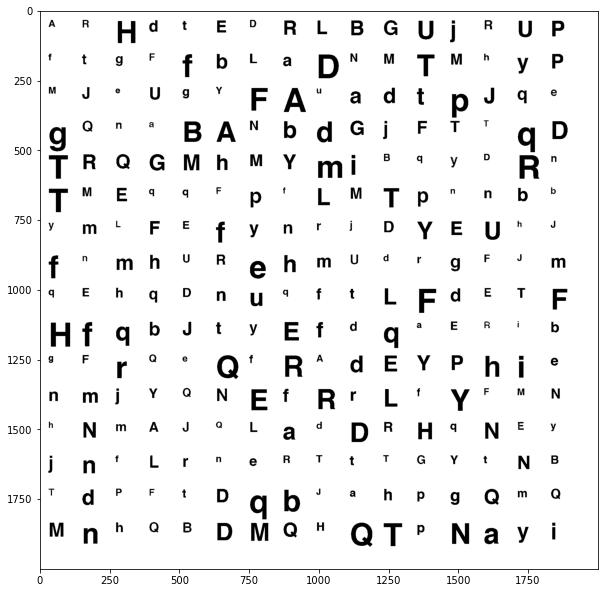

In [268]:
# apply Sauvola local adaptive thresholding
img = cv2.imread(f'{BASE_PATH}/test_img.jpg', cv2.IMREAD_GRAYSCALE)
bin_img = otsu(img, 100)
plt.figure(figsize=(10, 12))
_ = plt.imshow(bin_img, cmap='gray')

In [243]:
# bin_img = expand(bin_img, 2)
heights = []
k = 0
components = defaultdict(dict)
flag = True
p = 0
h, w = bin_img.shape
bimg = bin_img.copy().astype(np.int16)

for i in range(h):
    temp = (bimg[i, :] == 0.).any()
    if temp == flag:
        if flag:
            heights.append([i])
        else:
            heights[-1].append(i)
        flag = not flag
        
for i in range(h):
    for j in range(w):
        if bimg[i][j] == 255:
            bimg[i][j] = -1
        
for h1, h2 in heights:
    p = connected_components(
        bimg[h1:h2+1, :],
        p,
        components,
        h1,
        foreground=0,
    )

In [216]:
all_character_imgs = glob.glob(f'{BASE_PATH}/characters/' + "/*")
characters = {}

for each_character in all_character_imgs:
    character_name = "{}".format(os.path.split(each_character)[-1].split('.')[0])
    characters[character_name] = read_image(each_character, show=False)

In [219]:
len(components.keys()), characters.keys()

(265, dict_keys(['M', 'B', 'T', 'a']))

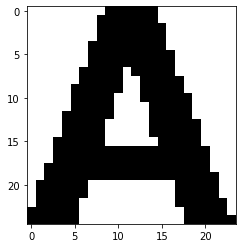

In [180]:
_, test_img = get_component(components, 0, bin_img, show=True)

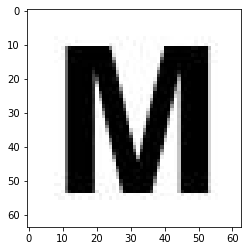

In [181]:
actual_img = characters['M']
plt.imshow(actual_img, cmap='gray')

In [147]:
_, test = extract_features(test_img, sift)
_, actual = extract_features(actual_img, sift)
dist = matcher(test, actual, norm_l2)
print(dist)
sum(dist)/len(dist)

[231.09, 250.97, 521.53, 566.94]


392.63250732421875

0.2546906314839996


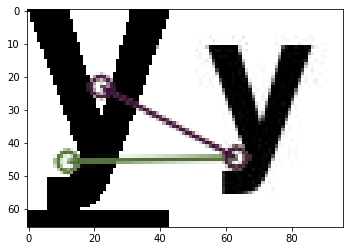

In [165]:
_, score, im = recog_sift.match(test_img, actual_img)
print(score)
_ = plt.imshow(im, cmap='gray')

0.21934996076724902


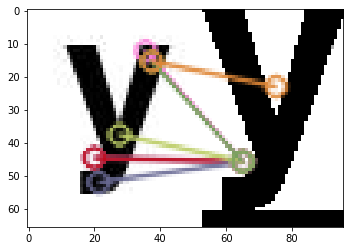

In [164]:
_, score, im = recog_sift.match(actual_img, test_img)
print(score)
_ = plt.imshow(im, cmap='gray')

In [524]:
with open(f'{BASE_PATH}/groundtruth.json') as f:
    gt = eval(f.read())
    
with open(f'{BASE_PATH}/results.json') as f:
    results = eval(f.read())

In [525]:
res = []
for idx, mp in enumerate(gt):
    if mp['name'] != 'UNKNOWN':
        res.append((idx, mp))
        
len(res), res

(33,
 [(9, {'bbox': [1114, 33, 45, 54], 'name': 'B'}),
  (23, {'bbox': [870, 163, 32, 35], 'name': 'a'}),
  (26, {'bbox': [1232, 152, 37, 37], 'name': 'M'}),
  (27, {'bbox': [1351, 155, 64, 79], 'name': 'T'}),
  (28, {'bbox': [1473, 152, 39, 40], 'name': 'M'}),
  (32, {'bbox': [31, 271, 25, 25], 'name': 'M'}),
  (41, {'bbox': [1111, 287, 40, 45], 'name': 'a'}),
  (51, {'bbox': [390, 397, 18, 20], 'name': 'a'}),
  (52, {'bbox': [517, 395, 62, 74], 'name': 'B'}),
  (60, {'bbox': [1470, 393, 34, 41], 'name': 'T'}),
  (61, {'bbox': [1589, 391, 19, 23], 'name': 'T'}),
  (64, {'bbox': [31, 516, 69, 85], 'name': 'T'}),
  (68, {'bbox': [515, 513, 56, 58], 'name': 'M'}),
  (70, {'bbox': [753, 513, 43, 43], 'name': 'M'}),
  (74, {'bbox': [1232, 511, 22, 27], 'name': 'B'}),
  (80, {'bbox': [31, 636, 69, 85], 'name': 'T'}),
  (81, {'bbox': [152, 631, 32, 33], 'name': 'M'}),
  (89, {'bbox': [1113, 632, 40, 41], 'name': 'M'}),
  (90, {'bbox': [1230, 634, 58, 70], 'name': 'T'}),
  (142, {'bbox': [171

In [419]:
res = []
for idx, mp in enumerate(results):
    if mp['name'] != 'UNKNOWN':
        res.append((idx, mp))
        
len(res), res[12]

(261, (12, {'bbox': [1470, 50, 18, 62], 'name': 'M'}))

In [421]:
[(9, {'bbox': [1114, 33, 45, 54], 'name': 'B'}), (32, {'bbox': [31, 271, 25, 25], 'name': 'M'}), (52, {'bbox': [517, 395, 62, 74], 'name': 'B'}), (60, {'bbox': [1470, 393, 34, 41], 'name': 'T'}), (64, {'bbox': [31, 516, 69, 85], 'name': 'T'}), (70, {'bbox': [753, 513, 43, 43], 'name': 'M'}), (74, {'bbox': [1232, 511, 22, 27], 'name': 'B'}), (80, {'bbox': [31, 636, 69, 85], 'name': 'T'}), (81, {'bbox': [152, 631, 32, 33], 'name': 'M'}), (89, {'bbox': [1113, 632, 40, 41], 'name': 'M'}), (90, {'bbox': [1230, 634, 58, 70], 'name': 'T'}), (190, {'bbox': [1711, 1352, 25, 25], 'name': 'M'}), (223, {'bbox': [1832, 1592, 26, 31], 'name': 'B'}), (244, {'bbox': [513, 1832, 31, 37], 'name': 'B'}), (246, {'bbox': [755, 1834, 64, 65], 'name': 'M'}), (250, {'bbox': [1231, 1835, 67, 83], 'name': 'T'})]

{'left': 50, 'right': 111, 'top': 1470, 'bottom': 1487}

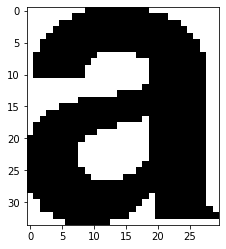

In [443]:
_, test_img = get_component(components, 24, bin_img, show=True)

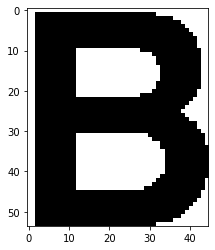

In [526]:
actual_img = groundtruth(9, bin_img, show=True)

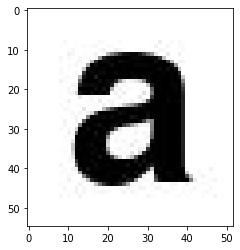

In [273]:
plt.imshow(characters['a'], cmap='gray')

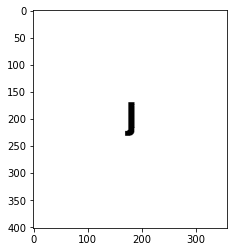

In [430]:
test_img = np.pad(test_img, 41, constant_values=255.)
plt.imshow(test_img, cmap='gray')

n_matches: 11
0.23923446365430484


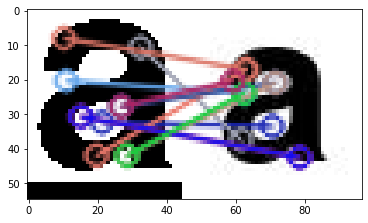

In [311]:
_, score, im = recog_sift.match(test_img, characters['a'])
print(score)
_ = plt.imshow(im, cmap='gray')

n_matches: 11
0.2600530017580604


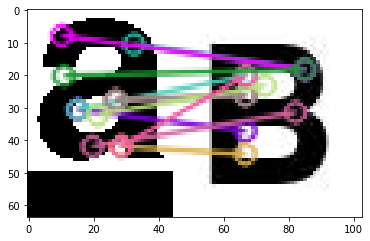

In [312]:
_, score, im = recog_sift.match(test_img, characters['B'])
print(score)
_ = plt.imshow(im, cmap='gray')

In [473]:
_, test = extract_features(test_img, sift)
_, actual = extract_features(characters['a'], sift)
dist = matcher(test, actual, norm_l2, thresh=0.8)
print(dist)
sum(dist)/len(dist) if dist else float('inf')

0.88835573
0.39288944
0.97882026
0.99917126
0.8953967
0.9536922
0.7290872
0.87727773
0.8682576
0.88576835
0.9464694
0.948741
[203.08, 292.27]


247.67499542236328

In [469]:
_, test = extract_features(test_img, sift)
_, actual = extract_features(characters['B'], sift)
dist = matcher(test, actual, norm_l2)
print(dist)
sum(dist)/len(dist) if dist else float('inf')

0.9941274
0.99285954
0.9972472
0.9942886
0.9645573
0.94151425
0.974403
0.9956911
0.9364687
0.88539135
0.9938123
0.9153047
[]


inf

In [470]:
_, test = extract_features(test_img, sift)
_, actual = extract_features(characters['M'], sift)
dist = matcher(test, actual, norm_l2)
print(dist)
sum(dist)/len(dist) if dist else float('inf')

0.956156
0.8535225
0.98481333
0.9923658
0.94023395
0.9272977
0.9350012
0.9932465
0.9952089
0.99409246
0.9985002
0.97012395
[]


inf

In [471]:
_, test = extract_features(test_img, sift)
_, actual = extract_features(characters['T'], sift)
dist = matcher(test, actual, norm_l2)
print(dist)
sum(dist)/len(dist) if dist else float('inf')

0.8838349
0.9973734
0.93429434
0.9208292
0.9876695
0.9771749
0.93178445
0.94988513
0.9899494
0.9463995
0.945687
0.91106963
[]


inf